# Using K-means for color compression 



Note that this notebook is intended as a demonstrative example of how the K-means algorithm works. Its focus is on the theory and results of its application, not on the code itself (which you will learn later). As such, it differs from other notebooks that accompany video lessons.

Specifically, some of the steps in the code exceed the scope of what is taught in the lessons. **Pay attention to the cells' output, and not so much to the code that generates it.** 

This lab will:

  * Give you a worked example of K-means on non-synthetic data
  * Reinforce your understanding of K-means' underlying theory by demonstrating its affect when applied to a photograph

As we move forward, you can find instructions on how to install required libraries as they arise in this notebook. 

## Modeling objective

We will use K-means to cluster the pixels of a photograph of some tulips based on their encoded color values. We will explore how different values of _k_ affect the clustering of the pixels, and thus the appearance of the photograph. We will also examine what is happening "under the hood" as the algorithm executes.

**NOTE: This notebook contains interactive plots that must be generated each time the notebook is opened. To ensure that the plots display, navigate to "Kernel" in the menu at the top of the notebook and click "Restart & Run All" from the dropdown menu.**

## Import statements

We will be using numpy and pandas for operations, and Plotly for 3-D visualization. Of particular note is `Kmeans`, which is scikit-learn's implementation of the K-means algorithm. 

In [21]:
!pip install plotly

import numpy as np
import pandas as pd

%pylab inline
import plotly.graph_objects as go

from sklearn.cluster import KMeans

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\Miss Sera\AppData\Roaming\Python\Python313\site-packages\IPython\core\magics\pylab.py:166: UserWarning:

pylab import has clobbered these variables: ['trace']
`%matplotlib` prevents importing * from pylab and numpy



## Read in data

The "data" in this case is not a pandas dataframe. It's a photograph, which we'll convert into a numerical array.

In [22]:
# Read in a photo
img = plt.imread('using_kmeans_for_color_compression_tulips_photo.jpeg')

(320, 240, 3)


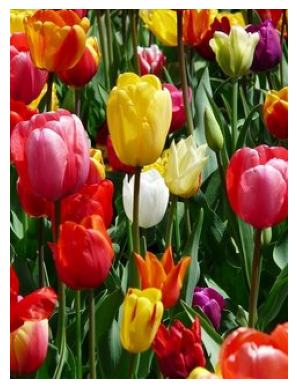

In [23]:
# Display the photo and its shape
print(img.shape)
plt.imshow(img)
plt.axis('off');

Here we have a photograph of some tulips. The shape of the image is 320 x 240 x 3. This can be interpreted as pixel information. Each dot on your screen is a pixel. This photograph has 320 vertical pixels and 240 horizontal pixels. 

But what is the third dimension of "3"? This dimension refers to the values that encode the color of each pixel. Each pixel has 3 parameters: red (R), green (G), and blue (B), also known as its RGB values. For each color—R, G, and B—the encoded value can range from 0-255. This means that there are 256³, or 16,777,216 different combinations of RGB, each resulting in a unique color on your screen. 

To prepare this data for modeling, we'll reshape it into an array, where each row represents a single pixel's RGB color values. 

In [24]:
# Reshape the image so that each row represents a single pixel 
# defined by three values: R, G, B
img_flat = img.reshape(img.shape[0]*img.shape[1], 3)
img_flat[:5, :]

array([[211, 197,  38],
       [199, 181,  21],
       [178, 154,   0],
       [185, 152,   0],
       [184, 145,   0]], dtype=uint8)

In [25]:
img_flat.shape

(76800, 3)

## Plot the data in 3-D space

Now we have an array that is 76,800 x 3. Each row is a single pixel's color values. Because we have only 3 columns, we can visualize this data in 3-dimensional space. Let's create a pandas dataframe to help us understand and visualize our data.

In [26]:
# Create a pandas df with r, g, and b as columns
img_flat_df = pd.DataFrame(img_flat, columns = ['r', 'g', 'b'])
img_flat_df.head()



r    g   b
0  211  197  38
1  199  181  21
2  178  154   0
3  185  152   0
4  184  145   0

**Note:** The following cell's output is viewable in two ways: You can re-run this cell, or manually convert the notebook to "Trusted." 

In [27]:
# Create 3D plot where each pixel in the `img` is displayed in its actual color


trace = go.Scatter3d(x = img_flat_df.r,
                     y = img_flat_df.g,
                     z = img_flat_df.b,
                     mode='markers',
                     marker=dict(size=1,
                                 color=['rgb({},{},{})'.format(r,g,b) for r,g,b 
                                        in zip(img_flat_df.r.values, 
                                               img_flat_df.g.values, 
                                               img_flat_df.b.values)],
                                 opacity=0.5))

data = [trace]

layout = go.Layout(margin=dict(l=0,
                               r=0,
                               b=0,
                               t=0),
                               )

fig = go.Figure(data=data, layout=layout)
fig.update_layout(scene = dict(
                    xaxis_title='R',
                    yaxis_title='G',
                    zaxis_title='B'),
                  )
import plotly.io as pio
pio.renderers.default = 'browser'

fig.show()

In this graph, each dot represents a color/pixel that is in our original image of tulips. The more intense the color, the more dots are concentrated in that area. The most-represented colors in the graph are the most abundant colors in the photograph: mostly reds, greens, and yellows. You can click and spin this graph to examine it from different angles. You can also zoom in and out.

We can train a K-means model on this data. The algorithm will create _k_ clusters by minimizing the squared distances from each point to its nearest centroid. 

Let's first do an experiment. What would you expect to happen if we built a K-means model with just a single centroid (_k_ = 1) and replaced each pixel in the photograph with the RGB value of that centroid? What would the photograph look like?

Let's try it. 

## Cluster the data: _k_ = 1

In [28]:
# Instantiate the model
kmeans = KMeans(n_clusters=1, random_state=42).fit(img_flat)

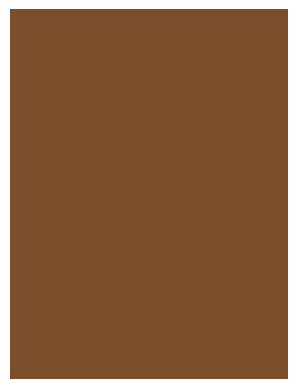

In [29]:
# Copy `img_flat` so we can modify it
img_flat1 = img_flat.copy()

# Replace each row in the original image with its closest cluster center
for i in np.unique(kmeans.labels_):
    img_flat1[kmeans.labels_==i,:] = kmeans.cluster_centers_[i]

# Reshape the data back to (640, 480, 3)
img1 = img_flat1.reshape(img.shape)

plt.imshow(img1)
plt.axis('off');

So what happened? Well, let's run through the K-means steps:

1. We randomly placed our centroid in the colorspace.
2. We assigned each point to its nearest centroid. Since there was only one centroid, all points were assigned to the same centroid, and thus to the same cluster.
3. We updated the centroid's location to the mean location of all of its points. Again, since there is only a single centroid, it updated to the mean location of every point in the image.
4. Repeat until the model converges. In this case, it only took one iteration for the model to converge. 

We then updated each pixel's RGB values to be the same as the centroid's. The result is the image of our tulips when every pixel is replaced with the average color. The average color of this photo was brown⁠—all the colors muddled together.

We can verify this for ourselves by manually calculating the average for each column in the flattened array. This will give us the average R value, G value, and B value. 

In [30]:
# Calculate mean of each column in the flattened array
column_means = img_flat.mean(axis=0)

print('column means: ', column_means)

column means:  [125.60802083  78.90632813  43.45473958]


Now, we can compare this to what the K-means model calculated as the final location of its one centroid.

In [31]:
print('cluster centers: ', kmeans.cluster_centers_)

cluster centers:  [[125.60802083  78.90632813  43.45473958]]


They're the same! Now, let's return to the 3-D rendering of our data, only this time we'll add the centroid.

In [32]:
# Create 3-D plot where each pixel in the `img` is displayed in its actual color
trace = go.Scatter3d(x = img_flat_df.r,
                     y = img_flat_df.g,
                     z = img_flat_df.b,
                     mode='markers',
                     marker=dict(size=1,
                                 color=['rgb({},{},{})'.format(r,g,b) for 
                                        r,g,b in zip(img_flat_df.r.values, 
                                                     img_flat_df.g.values, 
                                                     img_flat_df.b.values)],
                                 opacity=0.5))

data = [trace]

layout = go.Layout(margin=dict(l=0,
                               r=0,
                               b=0,
                               t=0))

fig = go.Figure(data=data, layout=layout)


# Add centroid to chart
centroid = kmeans.cluster_centers_[0].tolist()

fig.add_trace(
    go.Scatter3d(x = [centroid[0]],
                 y = [centroid[1]],
                 z = [centroid[2]],
                 mode='markers',
                 marker=dict(size=7,
                             color=['rgb(125.79706706,78.8178776,42.58090169)'],
                             opacity=1))
)
fig.update_layout(scene = dict(
                    xaxis_title='R',
                    yaxis_title='G',
                    zaxis_title='B'),
                  )
fig.show()

We can see the centroid as a large circle in the middle of the colorspace. (If you can't, just click on the image and spin/zoom it.) Notice that this is the "center of gravity" of all the points in the graph.

Now let's try something else. Let's refit a K-means model to the data, this time using _k_ = 3. Take a moment to consider what you might expect to result from this. Go through the steps of what the model is doing like we did above. What colors are you likely to see?

## Cluster the data: _k_ = 3

In [33]:
# Instantiate k-means model for 3 clusters
kmeans3 = KMeans(n_clusters=3, random_state=42).fit(img_flat)

# Check the unique values of what's returned by the .labels_ attribute 
np.unique(kmeans3.labels_)

array([0, 1, 2], dtype=int32)

The `.cluster_centers_` attribute returns an array where each element represents the coordinates of a centroid (i.e., their RGB values). We'll use these coordinates as we did previously to generate the colors that are represented by our centroids.

In [34]:
# Assign centroid coordinates to `centers` variable
centers = kmeans3.cluster_centers_
centers

array([[202.94809272, 174.18418712, 111.37454869],
       [ 41.26942958,  50.19883774,  15.9462609 ],
       [176.79647115,  43.60730575,  27.50588141]])

Now we'll create a helper function to easily display RGB values as color swatches, and use it to check the colors of the model's centroids.

In [35]:
# Helper function that creates color swatches
def show_swatch(RGB_value):
    '''
    Takes in an RGB value and outputs a color swatch
    '''
    R, G, B = RGB_value
    rgb = [[np.array([R,G,B]).astype('uint8')]]
    plt.figure()
    plt.imshow(rgb)
    plt.axis('off');

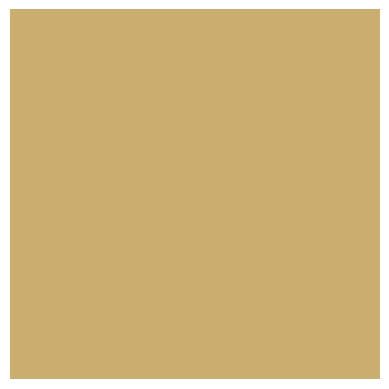

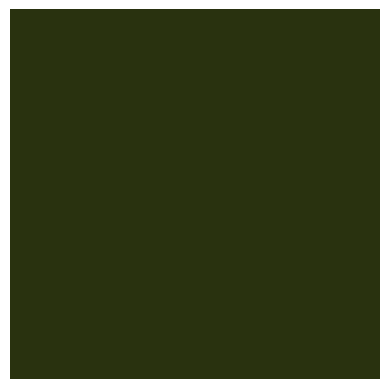

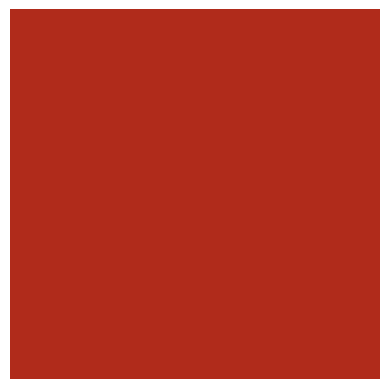

In [36]:
# Display the color swatches
for pixel in centers:
    show_swatch(pixel)

Hopefully, you hypothesized that we'd see similar colors as a result of a 3-cluster model. If you examine the original image of the tulips, it's apparent that there are generally three dominant colors: reds, greens, and golds/yellows, which is very close to what the model returned.

Just as before, let's now replace each pixel in the original image with the RGB value of the centroid to which it was assigned.

In [37]:
# Helper function to display our photograph when clustered into k clusters
def cluster_image(k, img=img):
    '''
    Fits a K-means model to a photograph.
    Replaces photo's pixels with RGB values of model's centroids.
    Displays the updated image.

    Args:
      k:    (int)          - Your selected K-value
      img:  (numpy array)  - Your original image converted to a numpy array

    Returns:
      The output of plt.imshow(new_img), where new_img is a new numpy array
      where each row of the original array has been replaced with the
      coordinates of its nearest centroid.
    '''

    img_flat = img.reshape(img.shape[0]*img.shape[1], 3)
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(img_flat)
    new_img = img_flat.copy()
  
    for i in np.unique(kmeans.labels_):
        new_img[kmeans.labels_ == i, :] = kmeans.cluster_centers_[i]
  
    new_img = new_img.reshape(img.shape)

    return plt.imshow(new_img), plt.axis('off');
  

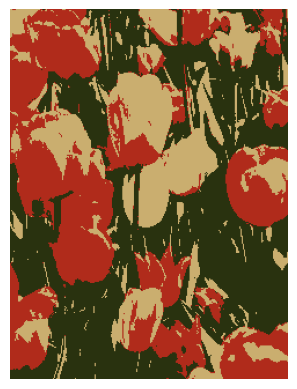

In [38]:
# Generate image when k=3
cluster_image(3);

We now have a photo with just three colors. Each pixel's RGB values correspond to the values of its nearest centroid. 

We can return once more to our 3-D colorspace. This time, we'll re-color each dot in the colorspace to correspond with the color of its centroid. This will allow us to see how the K-means algorithm clustered our data spatially. 

Again, don't concern yourself so much with the code. Feel free to skip down to the graph.

In [39]:
# Just to get an understanding of what the data structures look like

print(kmeans3.labels_.shape)
print(kmeans3.labels_)
print(np.unique(kmeans3.labels_))
print(kmeans3.cluster_centers_)

(76800,)
[0 0 2 ... 2 2 2]
[0 1 2]
[[202.94809272 174.18418712 111.37454869]
 [ 41.26942958  50.19883774  15.9462609 ]
 [176.79647115  43.60730575  27.50588141]]


In [40]:
# Create a new column in the df that indicates the cluster number of each row 
# (as assigned by Kmeans for k=3)
img_flat_df['cluster'] = kmeans3.labels_
img_flat_df.head()

r    g   b  cluster
0  211  197  38        0
1  199  181  21        0
2  178  154   0        2
3  185  152   0        2
4  184  145   0        2

In [41]:
# Create helper dictionary to map RGB color values to each observation in df
series_conversion = {
    i: 'rgb({:d},{:d},{:d})'.format(*tuple(map(int, kmeans3.cluster_centers_[i])))
    for i in range(3)
}
series_conversion

{0: 'rgb(202,174,111)', 1: 'rgb(41,50,15)', 2: 'rgb(176,43,27)'}

In [42]:
# Replace the cluster numbers in the 'cluster' col with formatted RGB values 
# (made ready for plotting)
img_flat_df['cluster'] = img_flat_df['cluster'].map(series_conversion)
img_flat_df.head()

r    g   b           cluster
0  211  197  38  rgb(202,174,111)
1  199  181  21  rgb(202,174,111)
2  178  154   0    rgb(176,43,27)
3  185  152   0    rgb(176,43,27)
4  184  145   0    rgb(176,43,27)

In [ ]:
# Replot the data, now showing which cluster (i.e., color) it was assigned to by K-means when k=3

trace = go.Scatter3d(x = img_flat_df.r,
                     y = img_flat_df.g,
                     z = img_flat_df.b,
                     mode='markers',
                     marker=dict(size=1,
                                 color=img_flat_df.cluster,
                                 opacity=1))

data = trace

layout = go.Layout(margin=dict(l=0,
                               r=0,
                               b=0,
                               t=0))

fig = go.Figure(data=data, layout=layout)
fig.show()

You may be thinking to yourself that you would have clustered the data differently based on the distribution of points that you saw in the first 3-D plot. For example, why is there a sharp line that separates red and green, when there doesn't appear to be any empty space there in the data?

You're not incorrect. Even though there's no such thing as "wrong" clustering, some ways can definitely be better than others. 

You'll notice in the original 3-D rendering that there are long bands—not round balls—of clustered data. K-means works best when the clusters are more circular, because it tries to minimize distance from point to centroid. It may be worth trying a different clustering algorithm if you want to cluster a long, narrow, continuous band of data. (More on these later!)

Nonetheless, K-means successfully compresses the colors of this photograph. This process can be applied for any value of _k_. Here's the output of each photo for _k_ = 2–10.

## Cluster the data: _k_ = 2-10

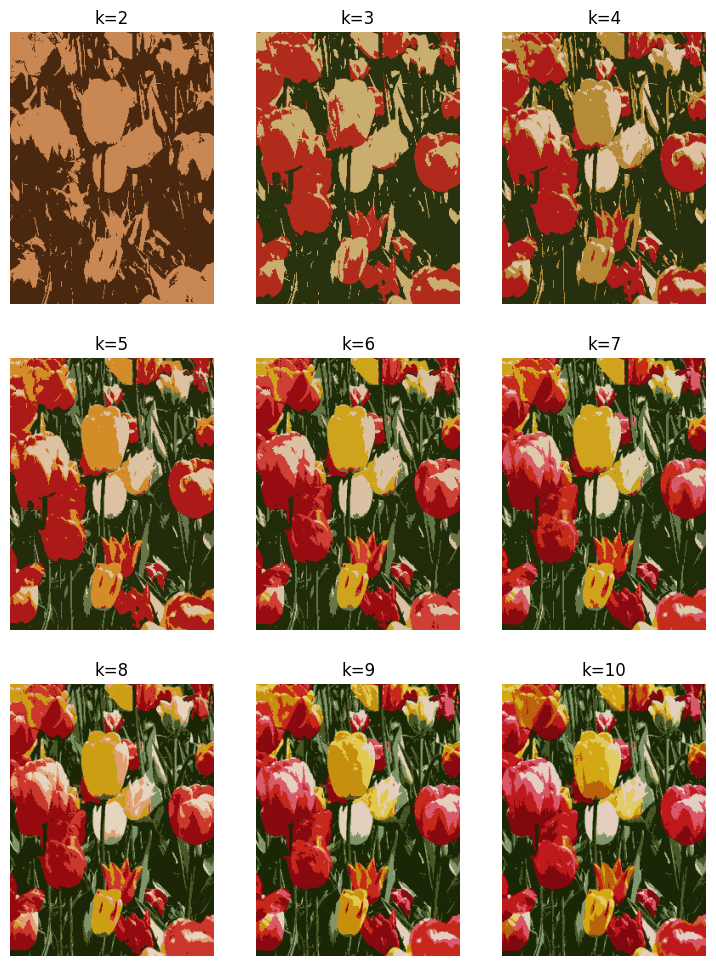

In [ ]:
# Helper function to plot image grid
def cluster_image_grid(k, ax, img=img):
    '''
    Fits a K-means model to a photograph.
    Replaces photo's pixels with RGB values of model's centroids.
    Displays the updated image on an axis of a figure.

    Args:
      k:    (int)          - Your selected K-value
      ax:   (int)          - Index of the axis of the figure to plot to
      img:  (numpy array)  - Your original image converted to a numpy array

    Returns:
      A new image where each row of img's array has been replaced with the 
      coordinates of its nearest centroid. Image is assigned to an axis that 
      can be used in an image grid figure.
    '''
    img_flat = img.reshape(img.shape[0]*img.shape[1], 3)
    kmeans = KMeans(n_clusters=k, random_state=42).fit(img_flat)
    new_img = img_flat.copy()

    for i in np.unique(kmeans.labels_):
        new_img[kmeans.labels_==i, :] = kmeans.cluster_centers_[i]

    new_img = new_img.reshape(img.shape)
    ax.imshow(new_img)
    ax.axis('off')

fig, axs = plt.subplots(3, 3)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 12)
axs = axs.flatten()
k_values = np.arange(2, 11)
for i, k in enumerate(k_values):
    cluster_image_grid(k, axs[i], img=img)
    axs[i].title.set_text('k=' + str(k))

Notice that it becomes increasingly difficult to see the difference between the images each time a color is added. This is a visual example of something that happens with all clustering models, even if the data is not an image that you can see. As you group the data into more and more clusters, additional clusters beyond a certain point contribute less and less to your understanding of your data.

Hopefully, this demonstration has deepened your understanding of how the K-means algorithm works. Soon, we’ll explore methods for numerically determining which _k_ value is best for particular data. As always, feel free to explore the notebook more on your own to keep building your skillset!



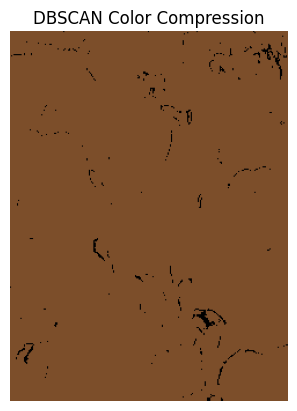

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def compress_image_dbscan(img, eps=10, min_samples=50):
    """
    Compresses an image’s colors by:
      1) Flattening the image to Nx3 (RGB).
      2) Clustering with DBSCAN.
      3) Computing each cluster’s mean color.
      4) Replacing each pixel with its cluster’s mean color (outliers get black).
      
    Args:
        img (numpy array): The original image array of shape (H, W, 3).
        eps (float): The maximum distance for two points to be considered neighbors.
        min_samples (int): Minimum number of samples to form a dense region.
    
    Returns:
        compressed_img (numpy array): The color-compressed image array.
    """
    # 1) Flatten the image
    h, w, c = img.shape
    flat_img = img.reshape(-1, c)

    # 2) Fit DBSCAN on the flattened pixels
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(flat_img)

    # 3) Compute mean color for each cluster (ignoring outliers labeled as -1)
    unique_labels = np.unique(labels)
    centroids = {}
    for label in unique_labels:
        if label == -1:
            continue
        centroids[label] = flat_img[labels == label].mean(axis=0)

    # 4) Create new image with compressed colors
    compressed_flat = np.zeros_like(flat_img, dtype=np.float64)
    for i in range(len(flat_img)):
        label = labels[i]
        if label == -1:
            # Outlier: paint it black (or pick another strategy)
            compressed_flat[i] = [0, 0, 0]
        else:
            compressed_flat[i] = centroids[label]

    # Reshape to original dimensions and convert to uint8
    compressed_img = compressed_flat.reshape(h, w, c).astype(np.uint8)
    return compressed_img

# Example usage:
img = plt.imread('using_kmeans_for_color_compression_tulips_photo.jpeg')
compressed_img_dbscan = compress_image_dbscan(img, eps=15, min_samples=50)
plt.imshow(compressed_img_dbscan)
plt.title("DBSCAN Color Compression")
plt.axis('off')
plt.show()


In [ ]:
import plotly.graph_objects as go
import pandas as pd

def plot_dbscan_3d(img, eps=10, min_samples=50):
    """
    1) Flatten the image into Nx3 (RGB).
    2) Run DBSCAN on the flattened data.
    3) Map each cluster to a mean color (outliers are black).
    4) Plot the points in 3D with Plotly, colored by cluster.
    
    Args:
        img (numpy array): Image array of shape (H, W, 3).
        eps (float): DBSCAN neighborhood distance threshold.
        min_samples (int): DBSCAN minimum samples per cluster.
    """
    # Flatten the image
    h, w, c = img.shape
    flat_img = img.reshape(-1, c)
    
    # Run DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(flat_img)
    
    # Create a DataFrame for easy handling
    df = pd.DataFrame(flat_img, columns=['R','G','B'])
    df['cluster'] = labels
    
    # Assign a color to each cluster (mean color), outliers get black
    cluster_colors = {}
    for lbl in np.unique(labels):
        if lbl == -1:
            # Outlier => black
            cluster_colors[lbl] = "rgb(0,0,0)"
        else:
            mean_color = df[df['cluster'] == lbl][['R','G','B']].mean().astype(int)
            cluster_colors[lbl] = f"rgb({mean_color['R']},{mean_color['G']},{mean_color['B']})"
    
    # Map each point's cluster to its assigned color
    df['cluster_color'] = df['cluster'].map(cluster_colors)
    
    # Plotly 3D scatter
    trace = go.Scatter3d(
        x=df['R'],
        y=df['G'],
        z=df['B'],
        mode='markers',
        marker=dict(
            size=1,
            color=df['cluster_color'].tolist(),  # Must be a list of color strings
            opacity=1
        )
    )
    
    fig = go.Figure(data=[trace])
    fig.update_layout(
        title='DBSCAN 3D Plot',
        scene=dict(
            xaxis_title='R',
            yaxis_title='G',
            zaxis_title='B'
        ),
        margin=dict(l=0, r=0, b=0, t=30)
    )
    fig.show()

# Example usage:
img = plt.imread('using_kmeans_for_color_compression_tulips_photo.jpeg')
plot_dbscan_3d(img, eps=15, min_samples=50)


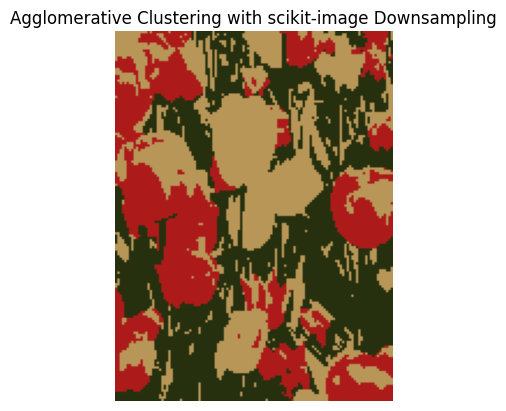

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from skimage.transform import resize
from skimage import io

def compress_image_agglomerative_scikit(img, n_clusters=3, downscale_factor=0.5):
    """
    Compress an image's colors using Agglomerative Clustering after downsampling the image.
    
    Args:
        img (numpy array): Input image array of shape (H, W, 3).
        n_clusters (int): Number of color clusters.
        downscale_factor (float): Factor to reduce image dimensions.
        
    Returns:
        compressed_img (numpy array): The color-compressed image.
        labels (numpy array): Cluster labels for each pixel in the downsampled image.
        flat_img (numpy array): Flattened downsampled image (each row is an RGB pixel).
    """
    # Downsample the image using scikit-image's resize
    h, w, c = img.shape
    img_small = resize(img, (int(h * downscale_factor), int(w * downscale_factor)),
                       anti_aliasing=True)
    
    # Flatten the downsampled image to a 2D array of pixels
    h_small, w_small, c = img_small.shape
    flat_img = img_small.reshape(-1, c)
    
    # Apply Agglomerative Clustering
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agg.fit_predict(flat_img)
    
    # Compute the mean color of each cluster
    unique_labels = np.unique(labels)
    centroids = {}
    for label in unique_labels:
        centroids[label] = flat_img[labels == label].mean(axis=0)
    
    # Replace each pixel's color with its cluster's mean color
    compressed_flat = np.zeros_like(flat_img)
    for label in unique_labels:
        compressed_flat[labels == label] = centroids[label]
    
    # Reshape to the downsampled image shape
    compressed_img = compressed_flat.reshape(h_small, w_small, c)
    return compressed_img, labels, flat_img

# Example usage:
img = io.imread('using_kmeans_for_color_compression_tulips_photo.jpeg')  # Replace with your image path

# Convert image to float in [0,1] if necessary (for skimage.resize)
if img.dtype == np.uint8:
    img = img.astype(np.float32) / 255.0

compressed_img, labels, flat_img = compress_image_agglomerative_scikit(img, n_clusters=3, downscale_factor=0.5)

plt.imshow(compressed_img)s
plt.title("Agglomerative Clustering with scikit-image Downsampling")
plt.axis('off')
plt.show()



In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Create a DataFrame for the downsampled pixels
# Note: flat_img values are in [0,1] so we'll scale them to [0,255] for plotting.
df = pd.DataFrame(flat_img, columns=['R', 'G', 'B'])
df['cluster'] = labels

# Map each cluster to its mean color (scaled to 0-255)
cluster_colors = {}
for lbl in np.unique(labels):
    # Compute mean color for cluster lbl (convert to 0-255)
    mean_color = (df[df['cluster'] == lbl][['R', 'G', 'B']].mean() * 255).astype(int)
    r, g, b = mean_color['R'], mean_color['G'], mean_color['B']
    cluster_colors[lbl] = f"rgb({r},{g},{b})"
    
df['cluster_color'] = df['cluster'].map(cluster_colors)

# Create a 3D scatter plot
trace = go.Scatter3d(
    x=df['R'] * 255,  # Scale back to 0-255
    y=df['G'] * 255,
    z=df['B'] * 255,
    mode='markers',
    marker=dict(
        size=2,
        color=df['cluster_color'].tolist(),  # Colors by cluster
        opacity=1
    )
)

fig = go.Figure(data=[trace])
fig.update_layout(
    title='3D Color Space (Agglomerative Clustering Result)',
    scene=dict(
        xaxis_title='R',
        yaxis_title='G',
        zaxis_title='B'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)
fig.show()
